In [134]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Preprocessing

### Import Dataset

In [135]:
df = pd.read_csv(
    "../Datasets/Raw_Data/GSE221521_gene_expression.csv", index_col=1)
df.head()

gene_id  \
gene_name                     
AC073488.4  ENSG00000282222   
AC119427.1  ENSG00000282221   
MIR543      ENSG00000212040   
MADD        ENSG00000110514   
AL356737.2  ENSG00000287159   

                                                  description  \
gene_name                                                       
AC073488.4  chromodomain protein, Y chromosome-like (CDYL)...   
AC119427.1                novel transcript, antisense to LAD1   
MIR543       microRNA 543 [Source:HGNC Symbol;Acc:HGNC:33664]   
MADD        MAP kinase activating death domain [Source:HGN...   
AL356737.2                novel transcript, antisense to GPC5   

                       gene_type                   locus  RNA1_FPKM  \
gene_name                                                             
AC073488.4  processed_pseudogene       X:9410789-9411545   0.000000   
AC119427.1                lncRNA   1:201399633-201401190   0.000000   
MIR543                     miRNA  14:101031987-101032064   0.000000   
MADD              protein_coding    11:47269161-47330031   6.345943   
AL356737.2                lncRNA    13:92610646-92677725   0.000000   

            RNA102_FPKM  RNA104_FPKM  RNA108_FPKM  RNA109_FPKM  RNA110_FPKM  \
gene_name                                                                     
AC073488.4     0.000000     0.000000     0.000000     0.000000     0.000000   
AC119427.1     0.000000     0.000000     0.000000     0.000000     0.000000   
MIR543         0.000000     0.000000     0.000000     0.000000     0.962816   
MADD           8.482109    10.209322     7.143557     5.671481     7.776351   
AL356737.2     0.000000     0.000000     0.000000     0.000000     0.000000   

            ...  R_JS032_count  R_JS033_count  R_JS034_count  R_JS035_count  \
gene_name   ...                                                               
AC073488.4  ...              0              0              0              0   
AC119427.1  ...              0              0              0              0   
MIR543      ...              0              0              0              0   
MADD        ...           1187           1254           1767           1184   
AL356737.2  ...              0              0              0              0   

            R_JS036_count  R_JS037_count  R_JS038_count  R_JS039_count  \
gene_name                                                                
AC073488.4              0              0              1              0   
AC119427.1              0              0              0              0   
MIR543                  0              0              0              0   
MADD                 2418           1294           1254           1461   
AL356737.2              0              0              0              0   

            R_JS040_count  R_JS041_count  
gene_name                                 
AC073488.4              0              0  
AC119427.1              0              0  
MIR543                  0              0  
MADD                 1323           1795  
AL356737.2              0              0  

[5 rows x 390 columns]

### Check Gene Types

In [136]:
df['gene_type'].value_counts()

protein_coding                        19973
lncRNA                                16889
processed_pseudogene                  10162
unprocessed_pseudogene                 2612
misc_RNA                               2220
snRNA                                  1910
miRNA                                  1879
TEC                                    1057
snoRNA                                  943
transcribed_unprocessed_pseudogene      938
transcribed_processed_pseudogene        500
rRNA_pseudogene                         496
IG_V_pseudogene                         187
IG_V_gene                               145
transcribed_unitary_pseudogene          138
TR_V_gene                               106
unitary_pseudogene                       98
TR_J_gene                                79
rRNA                                     53
scaRNA                                   49
polymorphic_pseudogene                   48
IG_D_gene                                37
TR_V_pseudogene                 

### Transform the Dataset

In [137]:
df = df[df['gene_type'] == 'protein_coding']
df = df.drop(['gene_type', 'description', 'gene_id', 'locus'], axis=1)
df = df.iloc[:, :193]
df = df.T
df.to_csv('../Datasets/Dataset05/data0.csv')

### Combine with Diagnosis

In [138]:
df = pd.read_csv('../Datasets/Dataset05/data0.csv', index_col=0)
diagnosis = pd.read_csv("../Datasets/Dataset05/Diagnosis.csv", index_col=0)
df['Diagnosis'] = diagnosis['Diagnosis']
df.to_csv('../Datasets/Dataset05/data1.csv')

df.head()

MADD     MAST2  SAA2-SAA4     ZNF32       GAN      LDB2  \
RNA1_FPKM     6.345943  0.869310        0.0  6.669253  0.600997  0.121834   
RNA102_FPKM   8.482109  1.497604        0.0  5.263004  0.462272  0.038527   
RNA104_FPKM  10.209322  1.885831        0.0  7.452189  0.700046  0.063072   
RNA108_FPKM   7.143557  1.245977        0.0  4.420808  0.509687  0.034258   
RNA109_FPKM   5.671481  0.994017        0.0  5.703096  0.825660  0.054506   

                 H1-4       PXK      PDHB    MRPL49  ...     NR3C2   KIAA0040  \
RNA1_FPKM    5.450828  3.172121  3.207153  3.651562  ...  0.621285  11.664482   
RNA102_FPKM  0.478827  3.930541  1.841688  1.888131  ...  0.479421  21.291014   
RNA104_FPKM  0.752462  4.926555  2.829375  1.847389  ...  0.760400  13.102977   
RNA108_FPKM  1.839159  4.577803  2.727531  2.966440  ...  0.647643  13.033451   
RNA109_FPKM  1.422458  4.101071  2.368380  3.620306  ...  0.648695  16.733625   

              GOLPH3L    TMEM123   FAM156A      OAZ3      RBM10    GALNT9  \
RNA1_FPKM    2.801987  81.061685  0.523514  0.125285  18.065813  0.000000   
RNA102_FPKM  3.758003  49.676983  0.433426  0.086437  17.878264  0.014690   
RNA104_FPKM  3.637416  64.876616  1.170805  0.074297  16.252944  0.028862   
RNA108_FPKM  4.811761  50.096703  0.790047  0.288212  15.934811  0.000000   
RNA109_FPKM  3.151027  51.256403  1.796418  0.206351  18.742771  0.000000   

               GABPB2  Diagnosis  
RNA1_FPKM    3.027988          1  
RNA102_FPKM  2.766359          2  
RNA104_FPKM  2.665226          1  
RNA108_FPKM  2.187239          1  
RNA109_FPKM  2.850764          0  

[5 rows x 19974 columns]

### Remove Patients who hasn't Diabetic

In [139]:
df = pd.read_csv('../Datasets/Dataset05/data1.csv', index_col=0)
df = df[df['Diagnosis'] != 0]
df['Diagnosis'] = df['Diagnosis'] - 1
df.to_csv("../Datasets/Dataset05/data2.csv")
df.head()

MADD     MAST2  SAA2-SAA4     ZNF32       GAN      LDB2  \
RNA1_FPKM     6.345943  0.869310        0.0  6.669253  0.600997  0.121834   
RNA102_FPKM   8.482109  1.497604        0.0  5.263004  0.462272  0.038527   
RNA104_FPKM  10.209322  1.885831        0.0  7.452189  0.700046  0.063072   
RNA108_FPKM   7.143557  1.245977        0.0  4.420808  0.509687  0.034258   
RNA110_FPKM   7.776351  1.354624        0.0  9.626660  0.395486  0.063997   

                 H1-4       PXK      PDHB    MRPL49  ...     NR3C2   KIAA0040  \
RNA1_FPKM    5.450828  3.172121  3.207153  3.651562  ...  0.621285  11.664482   
RNA102_FPKM  0.478827  3.930541  1.841688  1.888131  ...  0.479421  21.291014   
RNA104_FPKM  0.752462  4.926555  2.829375  1.847389  ...  0.760400  13.102977   
RNA108_FPKM  1.839159  4.577803  2.727531  2.966440  ...  0.647643  13.033451   
RNA110_FPKM  1.527150  2.418005  3.230785  0.829841  ...  0.197282   8.781973   

              GOLPH3L    TMEM123   FAM156A      OAZ3      RBM10    GALNT9  \
RNA1_FPKM    2.801987  81.061685  0.523514  0.125285  18.065813  0.000000   
RNA102_FPKM  3.758003  49.676983  0.433426  0.086437  17.878264  0.014690   
RNA104_FPKM  3.637416  64.876616  1.170805  0.074297  16.252944  0.028862   
RNA108_FPKM  4.811761  50.096703  0.790047  0.288212  15.934811  0.000000   
RNA110_FPKM  3.380305  37.731734  1.930544  0.150767  27.361029  0.036608   

               GABPB2  Diagnosis  
RNA1_FPKM    3.027988          0  
RNA102_FPKM  2.766359          1  
RNA104_FPKM  2.665226          0  
RNA108_FPKM  2.187239          0  
RNA110_FPKM  1.831605          0  

[5 rows x 19974 columns]

### Analyze the Dataset

In [140]:
df = pd.read_csv("../Datasets/Dataset05/data2.csv", index_col=0)
df.describe()

MADD       MAST2   SAA2-SAA4       ZNF32         GAN        LDB2  \
count  143.000000  143.000000  143.000000  143.000000  143.000000  143.000000   
mean     8.658170    1.327529    0.001504    6.372647    0.582227    0.083249   
std      1.938942    0.460811    0.017980    2.337213    0.215682    0.089025   
min      3.971689    0.574337    0.000000    2.474963    0.193987    0.000000   
25%      7.423736    1.054891    0.000000    4.788831    0.417409    0.036330   
50%      8.503730    1.268189    0.000000    6.024590    0.558853    0.063997   
75%     10.119130    1.534103    0.000000    7.460358    0.714797    0.103397   
max     15.254562    4.807743    0.215014   14.617876    1.350910    0.854209   

             H1-4         PXK        PDHB      MRPL49  ...       NR3C2  \
count  143.000000  143.000000  143.000000  143.000000  ...  143.000000   
mean     1.636191    3.111463    2.897131    2.389443  ...    0.613116   
std      1.231694    0.984633    0.618149    1.167790  ...    0.234622   
min      0.000000    1.087869    1.434133    0.819855  ...    0.076194   
25%      0.850127    2.520599    2.481220    1.385922  ...    0.419934   
50%      1.323694    2.931732    2.874940    2.007374  ...    0.617272   
75%      1.935803    3.534435    3.304256    3.412844  ...    0.770454   
max      8.263707    8.280116    5.549478    5.167538  ...    1.293344   

         KIAA0040     GOLPH3L     TMEM123     FAM156A        OAZ3       RBM10  \
count  143.000000  143.000000  143.000000  143.000000  143.000000  143.000000   
mean    11.335140    3.187668   54.780638    1.307344    0.163266   18.469396   
std      5.057276    1.030729   26.286169    0.386247    0.079455    3.659679   
min      0.787728    0.511200   18.512923    0.433426    0.000000    9.532172   
25%      8.142774    2.507303   39.946702    1.011597    0.108929   16.129581   
50%     10.737926    3.158813   48.331576    1.294026    0.160369   18.361989   
75%     13.402202    3.846389   60.705102    1.594931    0.216260   20.689919   
max     33.180755    6.010858  244.033944    2.148791    0.407890   33.881433   

           GALNT9      GABPB2   Diagnosis  
count  143.000000  143.000000  143.000000  
mean     0.010979    2.742478    0.468531  
std      0.018019    0.811594    0.500763  
min      0.000000    0.210262    0.000000  
25%      0.000000    2.267853    0.000000  
50%      0.000000    2.727112    0.000000  
75%      0.017115    3.197332    1.000000  
max      0.097895    4.996842    1.000000  

[8 rows x 19974 columns]

In [141]:
df.dtypes

MADD         float64
MAST2        float64
SAA2-SAA4    float64
ZNF32        float64
GAN          float64
              ...   
OAZ3         float64
RBM10        float64
GALNT9       float64
GABPB2       float64
Diagnosis      int64
Length: 19974, dtype: object

In [142]:
df.isnull().sum()

MADD         0
MAST2        0
SAA2-SAA4    0
ZNF32        0
GAN          0
            ..
OAZ3         0
RBM10        0
GALNT9       0
GABPB2       0
Diagnosis    0
Length: 19974, dtype: int64

# Feature Selection

### Select best Feature Selection Algorithm

In [143]:
df = pd.read_csv("../Datasets/Dataset05/data2.csv", index_col=0)

features = df.drop('Diagnosis', axis=1)
target = df['Diagnosis']

result_df = pd.DataFrame(
    columns=['Feature Selection Algorithm', 'Feature Count', 'Cross Validation Score'])

feature_counts = [25, 50, 100, 150, 200]

feature_selection_algorithms = [
    ('Information Gain (Mutual info)', mutual_info_classif),
    ('Correlation Coefficient', f_classif),
    ('Chi-Square', chi2),
    ('Feature Importance', RandomForestClassifier().fit(
        features, target).feature_importances_)
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for algo_name, algo_func in feature_selection_algorithms:
    for count in feature_counts:
        if algo_name == 'Feature Importance':
            selected_features = features.columns[algo_func.argsort(
            )[-count:][::-1]]
        else:
            selected_features = features.columns[algo_func(
                features, target)[0].argsort()[-count:][::-1]]

        clf = SVC(kernel='linear')
        cv_scores = cross_val_score(
            clf, features[selected_features], target, cv=cv)

        result_df = pd.concat([result_df, pd.DataFrame({
            'Feature Selection Algorithm': [algo_name],
            'Feature Count': [count],
            'Cross Validation Score': [f'{cv_scores.mean():.2f}+/-{cv_scores.std():.2f}']
        })], ignore_index=True)

print(result_df)

c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  135   139   144   185   192   194   208   249   250   251   252   253
   300   313   334   335   393   409   416   433   435   451   468   507
   565   587   650   717   760   764   784   786   797   803   852   853
   857   895   969  1097  1130  1135  1169  1184  1195  1209  1225  1261
  1265  1276  1279  1282  1287  1300  1308  1335  1340  1346  1353  1356
  1381  1396  1427  1453  1488  1535  1537  1551  1552  1665  1668  1715
  1755  1803  1809  1822  1855  1936  1957  1981  2017  2023  2078  2083
  2112  2191  2199  2200  2218  2237  2266  2278  2287  2321  2366  2374
  2376  2392  2408  2417  2458  2468  2476  2491  2581  2583  2592  2607
  2624  2629  2631  2644  2669  2681  2689  2695  2756  2803  2832  2857
  2858  2883  2986  2998  3089  3101  3109  3133  3154  3222  3237  3272
  3308  3326  3336  3353  3366  3370  3382  3395  3413  3446  3472  3486
  35

       Feature Selection Algorithm Feature Count Cross Validation Score
0   Information Gain (Mutual info)            25            0.59+/-0.13
1   Information Gain (Mutual info)            50            0.59+/-0.13
2   Information Gain (Mutual info)           100            0.59+/-0.13
3   Information Gain (Mutual info)           150            0.59+/-0.13
4   Information Gain (Mutual info)           200            0.59+/-0.13
5          Correlation Coefficient            25            0.53+/-0.09
6          Correlation Coefficient            50            0.53+/-0.09
7          Correlation Coefficient           100            0.53+/-0.09
8          Correlation Coefficient           150            0.53+/-0.09
9          Correlation Coefficient           200            0.53+/-0.09
10                      Chi-Square            25            0.53+/-0.09
11                      Chi-Square            50            0.53+/-0.09
12                      Chi-Square           100            0.53

### Check Feature Importance

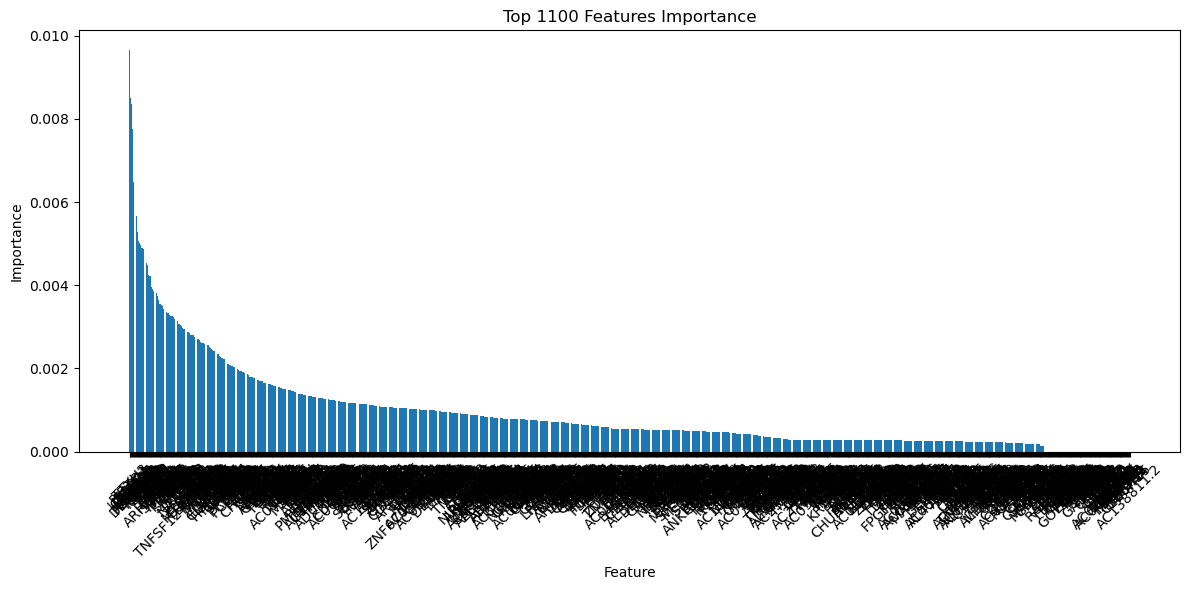

Last important feature:  1008


In [144]:
df = pd.read_csv("../Datasets/Dataset05/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_names = X.columns

k_values = [1100]

selected_features_dict = {}

for k in k_values:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_
    selected_features = np.array(feature_names)[
        np.argsort(feature_importances)[::-1][:k]]

    selected_features_dict[k] = selected_features

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Top {k} Features Importance")
    plt.bar(range(k), feature_importances[sorted_idx][:k], align="center")
    plt.xticks(range(k), np.array(feature_names)[sorted_idx][:k], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    zero_importance_index = np.where(feature_importances == 0)[0]
    print("Last important feature: ", len(
        X.columns)-len(zero_importance_index))

### Feature Selection

In [145]:
df = pd.read_csv("../Datasets/Dataset05/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_counts = list(range(1, 144))

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

feature_importances = clf.feature_importances_

selected_features = X.columns[np.argsort(feature_importances)[::-1]]

datasets = {}
for count in feature_counts:
    datasets[count] = X[selected_features[:count]].copy()
    datasets[count]['Diagnosis'] = y

for count, dataset in datasets.items():
    dataset.to_csv(
        f'../Datasets/Dataset05/Feature_Select/dataset_{count}.csv', index=True)

## Model Building

### Check CV Score for Different Models

In [146]:
feature_counts = list(range(1, 144))

models = {
    "SVM(linear)": SVC(kernel='linear'),
    "SVM(poly)": SVC(kernel='poly'),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "ANN": MLPClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

results = pd.DataFrame(
    columns=["Model Name", "Feature Count", "CV Score (Mean +/- Std)"])

for count in feature_counts:
    file_path = f"../Datasets/Dataset05/Feature_Select/dataset_{count}.csv"
    df = pd.read_csv(file_path, index_col=0)
    
    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    for model_name, model in models.items():
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        scores = cross_val_score(model, X, y, cv=cv)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        result = f"{mean_score:.4f} +/- {std_score:.4f}"
        results = results.append({"Model Name": model_name, "Feature Count": count,
                                 "CV Score (Mean +/- Std)": result}, ignore_index=True)

results.sort_values(by=["CV Score (Mean +/- Std)"],
                    ascending=False, inplace=True)
results.to_csv("../Datasets/Dataset05/Feature_Select/results.csv", index=False)

C:\Users\ACER\AppData\Local\Temp\ipykernel_25136\2224525216.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model Name": model_name, "Feature Count": count,
C:\Users\ACER\AppData\Local\Temp\ipykernel_25136\2224525216.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model Name": model_name, "Feature Count": count,
C:\Users\ACER\AppData\Local\Temp\ipykernel_25136\2224525216.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model Name": model_name, "Feature Count": count,
C:\Users\ACER\AppData\Local\Temp\ipykernel_25136\2224525216.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

In [147]:
df = pd.read_csv("../Datasets/Dataset05/Feature_Select/results.csv")
df.head(10)

Model Name  Feature Count CV Score (Mean +/- Std)
0        XGBoost            111       0.8069 +/- 0.0601
1        XGBoost             72       0.8069 +/- 0.0276
2        XGBoost            116       0.8000 +/- 0.0669
3        XGBoost            110       0.8000 +/- 0.0552
4  Random Forest             40       0.8000 +/- 0.0402
5        XGBoost             60       0.8000 +/- 0.0338
6        XGBoost             69       0.8000 +/- 0.0338
7        XGBoost             70       0.8000 +/- 0.0258
8        XGBoost             71       0.8000 +/- 0.0258
9        XGBoost             94       0.7931 +/- 0.0786

### Check Distributions

In [149]:
feature_count = 111

data = pd.read_csv(
    f'../Datasets/Dataset05/Feature_Select/dataset_{feature_count}.csv')

target_column = data.columns[feature_count + 1]

num_rows = math.ceil(feature_count / 4)
num_columns = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(80, 140))

for i in range(min(feature_count, num_rows * num_columns)):
    row_index = i // num_columns
    col_index = i % num_columns

    sns.histplot(
        data=data, x=data.columns[i + 1], hue=target_column, kde=True, ax=axes[row_index, col_index])

    axes[row_index, col_index].set_title(
        f'Distribution of {data.columns[i + 1]}')

    axes[row_index, col_index].set_xlabel(data.columns[i + 1])

    axes[row_index, col_index].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

### Check Accuracy

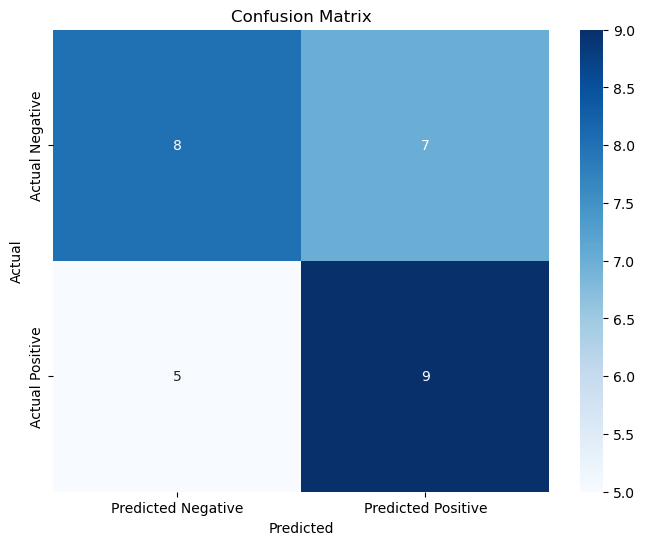

Accuracy: 0.59
Precision: 0.56
Recall (Sensitivity): 0.64
Specificity: 0.53
F1 Score: 0.60


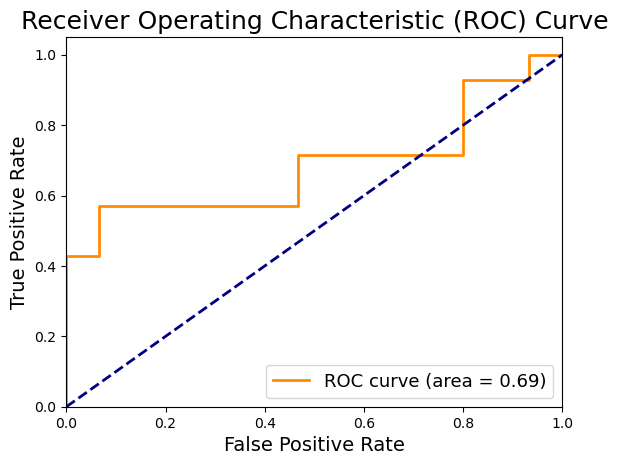

In [150]:
feature_count = 111

df = pd.read_csv(
    f'../Datasets/Dataset05/Feature_Select/dataset_{feature_count}.csv', index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_scores = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=13)
plt.show()